In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
%load_ext tensorboard
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
class GetFullDF:
    def __init__(self):
        self.df = None
    def __call__(self):
        if self.df is None:
            df = pd.concat([
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results_loss_not_normalized/results_gpt2meta', 'results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results_loss_not_normalized/results_gptj', 'results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results/results_gpt2meta/results.csv')),
#                 pd.read_csv(os.path.join('/scratch/mcinerney.de/metaicl/results/results_gptj', 'results.csv')),
                pd.read_csv('/scratch/mcinerney.de/metaicl/results/results_gpt2meta2/results_commonsense_qa.csv'),
#                 pd.read_csv('/scratch/mcinerney.de/metaicl/results/results_gpt2meta2/results_medical_questions_pairs.csv'),
#                 pd.read_csv('/scratch/mcinerney.de/metaicl/results/results_gpt2meta3/results_commonsense_qa.csv'),
            ])
            df = df.drop_duplicates(['task', 'train_data_split', 'train_indices', 'checkpoint'])
            df = df.reset_index()
            df['sampling'] = 'within_task_random'
            df['method'] = 'in_context'
            df['descriptor'] = df[['checkpoint', 'sampling', 'method']].apply(tuple, axis=1)
            df['logprob'] = -df['loss']
            df['prob'] = np.exp(-df['loss'])
            df['evaluated_on_size'] = df['evaluated_on'].apply(lambda x: len(eval(x)))
            df['normalizedlogprob'] = -df['normalized_loss']
            df['normalizedprob'] = np.exp(-df['normalized_loss'])
            self.df = df
        return self.df
get_full_df = GetFullDF()
def evaluate_prediction_dfs(train_df, val_df, key):
    print('train corr: %f, val corr: %f' % (
        train_df.regression_predictions.corr(train_df[key]),
        val_df.regression_predictions.corr(val_df[key])))
    chart = sns.scatterplot(data=train_df, x=key, y='regression_predictions', hue='task')
    plt.show()
    chart = sns.scatterplot(data=val_df, x=key, y='regression_predictions', hue='task')
    plt.show()

# Data

In [2]:
def get_breakdown(df):
    ckpts = sorted(list(set(df.checkpoint)))
    tasks = sorted(list(set(df.task)))
    samplings = sorted(list(set(df.sampling)))
    methods = sorted(list(set(df.method)))
    splits = list(set(df.train_data_split))
    evalsizes = list(set(df.evaluated_on_size))
    breakdown_df = pd.DataFrame({
        task: {
            (ch, sampling, method, split, evalsize): len(df[
                (df.task == task) & (df.checkpoint == ch) &
                (df.sampling == sampling) & (df.method == method) &
                (df.train_data_split == split) & (df.evaluated_on_size == evalsize)])
            for ch in ckpts for sampling in samplings for method in methods for split in splits for evalsize in evalsizes
        } for task in tasks}).transpose()
    print(len(breakdown_df))
    return breakdown_df
get_breakdown(get_full_df())

1


checkpoints/metaicl/hr_to_lr/model.pt                       
                                  within_task_random                       
                                          in_context                       
                                               train      val     val2     
                                                 64  200  64  200  64   200
commonsense_qa                                  2000   0  100   0    0  100

2000
with logprob
acc corr 0.5573790003921288


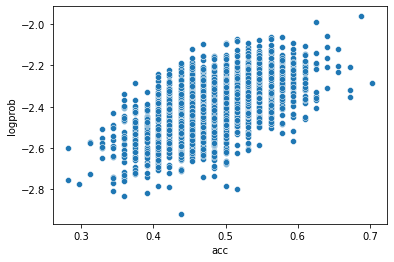

f1 corr 0.5507105824061681


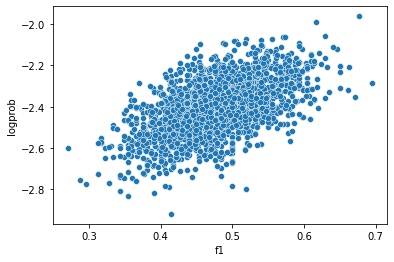

with prob
acc corr 0.5550403120688594


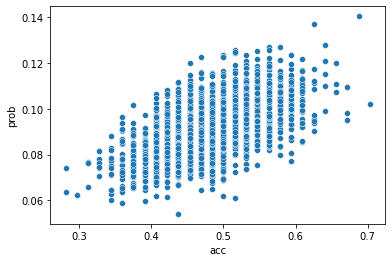

f1 corr 0.5482771268823909


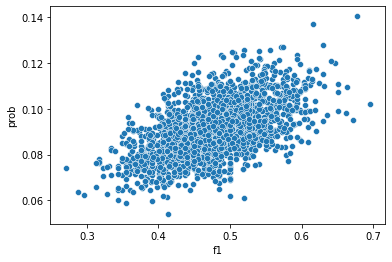

with normalized logprob
acc corr 0.7225816470735618


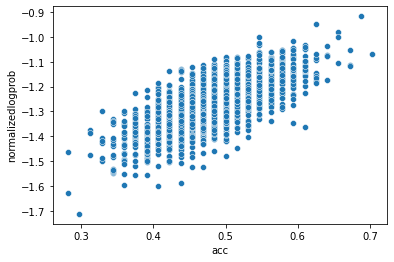

f1 corr 0.7183977400624437


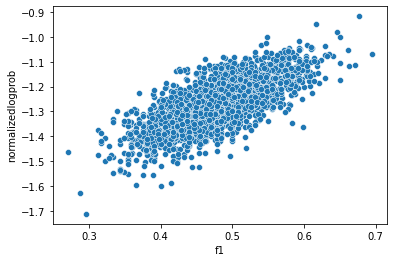

with normalized prob
acc corr 0.7239578521905183


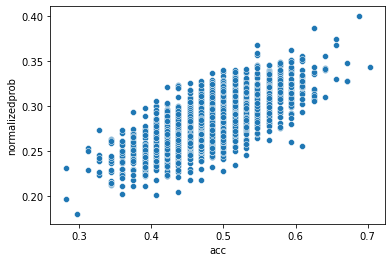

f1 corr 0.7197407272923035


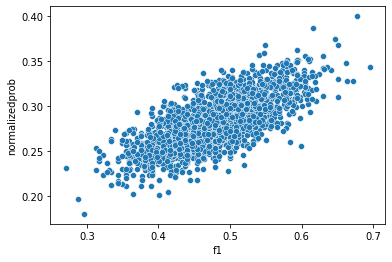

In [3]:
df = get_full_df()
df = df[
    (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt') &
    (df.task == 'commonsense_qa') &
    (df.train_data_split == 'train')
]
print(len(df))
print('with logprob')
print('acc corr', df.logprob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='logprob')
plt.show()
print('f1 corr', df.logprob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='logprob')
plt.show()
print('with prob')
print('acc corr', df.prob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='prob')
plt.show()
print('f1 corr', df.prob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='prob')
plt.show()
print('with normalized logprob')
print('acc corr', df.normalizedlogprob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='normalizedlogprob')
plt.show()
print('f1 corr', df.normalizedlogprob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='normalizedlogprob')
plt.show()
print('with normalized prob')
print('acc corr', df.normalizedprob.corr(df.acc))
sns.scatterplot(data=df, x='acc', y='normalizedprob')
plt.show()
print('f1 corr', df.normalizedprob.corr(df.f1))
sns.scatterplot(data=df, x='f1', y='normalizedprob')
plt.show()

In [4]:
def get_prompt(train_samples):
    train_samples = eval(train_samples)
    return '\n\n'.join(['input: %s\noutput: %s\n' % (dp['input'], dp['output']) for dp in train_samples])
class PromptPerformanceDataset(Dataset):
    def __init__(self, df, key):
        self.df = df
        self.key = key
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return dict(
            prompt=get_prompt(row.train_samples),
            label=row[self.key],
        )
class PromptsPerformanceData(pl.LightningDataModule):
    def __init__(self, get_df_func, key='normalizedlogprob', train_percent=.8, val_percent=.1, seed=0, no_example_overlap=False,
                 **dataloader_kwargs):
        super().__init__()
        self.get_df_func = get_df_func
        self.dataloader_kwargs = dataloader_kwargs
        self._train, self._val, self._test = None, None, None
        self.train_percent, self.val_percent, self.seed = train_percent, val_percent, seed
        self.no_example_overlap = no_example_overlap
        self.key = key
    def setup(self, stage=None):
        df = self.get_df_func()
        df = df[df.k != 0]
        if self.no_example_overlap:
            self._train, self._val, self._test = [
                PromptPerformanceDataset(df[df.train_data_split == split], self.key)
                for split in ['train', 'val', 'test']]
        else:
            df = df[df.train_data_split == 'train']
            length = len(df)
            train_length = int(length * self.train_percent)
            val_length = int(length * self.val_percent)
            lengths = [train_length, val_length, length - train_length - val_length]
            rows = [r for i, r in df.iterrows()]
            splits = random_split(rows, lengths, generator=torch.Generator().manual_seed(self.seed))
            self._train, self._val, self._test = [
                PromptPerformanceDataset(pd.DataFrame(list(x)), self.key) for x in splits]
    def train_dataloader(self):
        return DataLoader(self._train, **self.dataloader_kwargs, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self._val, **self.dataloader_kwargs)
    def test_dataloader(self):
        return DataLoader(self._test, **self.dataloader_kwargs)

# Linear Regression on per-example Binary Variables

In [5]:
def get_features(indices):
    x = np.zeros(500)
    x[np.array(indices)] = 1
    return x
def getxy(df, key):
    X = np.stack(df.apply(lambda r: get_features(eval(r.train_indices)), axis=1))
    y = np.array(df[key])
    return X, y
def setup_and_train_linear_regression(task, checkpoint, key, save_coefs=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df)
    dm.setup()
    X_train, y_train = getxy(dm._train.df, key)
    print('train shapes: X - %s, y - %s' % (str(X_train.shape), str(y_train.shape)))
    X_val, y_val = getxy(dm._val.df, key)
    print('val shapes: X - %s, y - %s' % (str(X_val.shape), str(y_val.shape)))
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
#     print(model.summary())
#     model = LinearRegression()
#     model.fit(X_train, y_train)
    if save_coefs:
        if not os.path.exists('regcoef'):
            os.mkdir('regcoef')
        if not os.path.exists(os.path.join('regcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('regcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.params[1:])
        if not os.path.exists('negregcoef'):
            os.mkdir('negregcoef')
        if not os.path.exists(os.path.join('negregcoef', checkpoint.replace('/', '-'))):
            os.mkdir(os.path.join('negregcoef', checkpoint.replace('/', '-')))
#         np.save(os.path.join('regcoef', checkpoint.replace('/', '-'), '%s.npy' % task), model.coef_)
        np.save(os.path.join('negregcoef', checkpoint.replace('/', '-'), '%s.npy' % task), -model.params[1:])
    return dm, model
def get_prediction_dfs_linear_regression(dm, model, key):
    X_train, y_train = getxy(dm._train.df, key)
#     y_train_pred = model.predict(X_train)
    y_train_pred = model.predict(sm.add_constant(X_train))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = y_train_pred
    X_val, y_val = getxy(dm._val.df, key)
#     y_val_pred = model.predict(X_val)
    y_val_pred = model.predict(sm.add_constant(X_val))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = y_val_pred
#     print('train regression score: %s, val regression score: %s' % (model.score(X_train, y_train), model.score(X_val, y_val)))
    return train_df, val_df

train shapes: X - (1600, 500), y - (1600,)
val shapes: X - (200, 500), y - (200,)
train corr: 0.585898, val corr: 0.075834


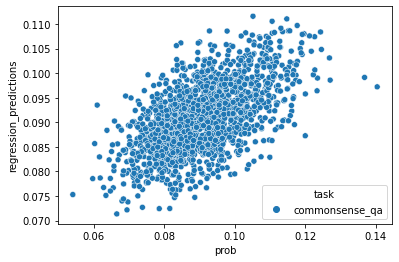

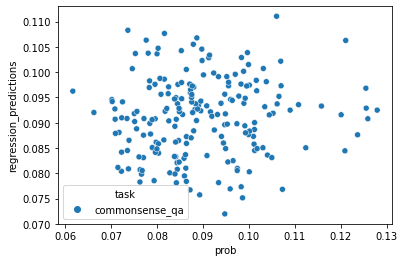

In [6]:
key = 'prob'
task = 'commonsense_qa'
# task = 'medical_questions_pairs'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

train shapes: X - (1600, 500), y - (1600,)
val shapes: X - (200, 500), y - (200,)
train corr: 0.557532, val corr: 0.077998


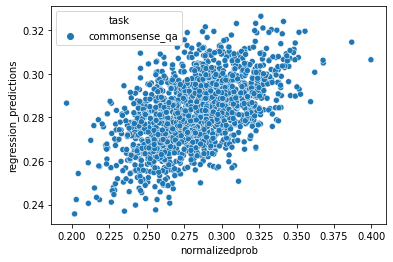

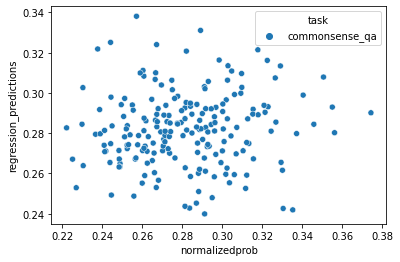

In [7]:
key = 'normalizedprob'
task = 'commonsense_qa'
# task = 'medical_questions_pairs'
dm, model = setup_and_train_linear_regression(
    task, 'checkpoints/metaicl/hr_to_lr/model.pt', key, save_coefs=True)
train_df, val_df = get_prediction_dfs_linear_regression(dm, model, key)
evaluate_prediction_dfs(train_df, val_df, key)

# Bert Regression

### Model

In [ ]:
class StringRegressionModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
        self.linear = nn.Linear(768, 1)
        self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        predictions = self.linear(out[1]).squeeze(-1)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = self.loss(predictions, batch['label'])
        self.log('loss/%s' % step_type, loss.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return self(batch).cpu().numpy()
class CollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor([i['label'] for i in instances], dtype=torch.float32)
        )
def setup_and_train_roberta_regression(task, checkpoint, key, epochs=10, batch_size=64, lr=1e-4, seed=0, no_example_overlap=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, key=key, batch_size=batch_size, collate_fn=CollateFn(), seed=seed,
                                no_example_overlap=no_example_overlap)
    dm.setup()
    model = StringRegressionModel(lr=lr)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def get_prediction_dfs_roberta_regression(trainer, dm, model):
    train_reg_preds = np.concatenate(trainer.predict(model, dm.train_dataloader()))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = train_reg_preds
    val_reg_preds = np.concatenate(trainer.predict(model, dm.val_dataloader()))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = val_reg_preds
    return train_df, val_df

### Training and evaluating the model

In [ ]:
# !kill 4849
%tensorboard --logdir=lightning_logs --port 6061

In [ ]:
key = 'normalizedlogprob'
trainer, dm, model = setup_and_train_roberta_regression(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5, no_example_overlap=True)
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df, key)

In [ ]:
key = 'normalizedlogprob'
trainer, dm, model = setup_and_train_roberta_regression(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5)
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df, key)

# Pairwise Ranking of Prompts

In [ ]:
class StringPairRankingModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
        self.linear = nn.Linear(768, 768)
        self.activation = nn.ReLU()
#         self.loss = nn.MSELoss()
        self.lr = lr
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, batch):
        out = self.model(**batch['text'])
        vecs1 = self.activation(self.linear(out[1]))
        vecs2 = out[1]
        predictions = torch.mm(vecs1, vecs2.transpose(0, 1))
        predictions = F.logsigmoid(predictions)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = -(predictions * batch['label']).sum()
        self.log('loss/%s' % step_type, loss.item())
        num_predictions = len(predictions) * (len(predictions) - 1)
        acc = (((torch.exp(predictions) > .5) * 2 - 1) == batch['label']).sum() / num_predictions
        self.log('acc/%s' % step_type, acc.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return torch.exp(self(batch)).cpu().numpy()
class PairRankingCollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        labels = []
        for i, i1 in enumerate(instances):
            labels.append([])
            for j, i2 in enumerate(instances):
                labels[-1].append(0 if i == j else 1 if i1['label'] > i2['label'] else -1)
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor(labels, dtype=torch.float32)
        )
def setup_and_train_roberta_pair_ranking(task, checkpoint, key, epochs=10, batch_size=64, lr=1e-4, seed=0, no_example_overlap=False):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, key=key, batch_size=batch_size, collate_fn=PairRankingCollateFn(),
                                seed=seed,
                                no_example_overlap=no_example_overlap)
    dm.setup()
    model = StringPairRankingModel(lr=lr)
    trainer = pl.Trainer(gpus=1, max_epochs=epochs, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def evaluate_roberta_pair_ranking(trainer, dm, model):
    raise NotImplementedError

In [ ]:
key = 'prob'
trainer, dm, model = setup_and_train_roberta_pair_ranking(
    'commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key, epochs=20, lr=1e-5, no_example_overlap=True)

# Per-example Correlation Coefficient Regression

For a given example, can we estimate how the correlation coefficient between including the example in the prompt and the score? If so, we would be able to estimate which examples are more positively correlated and use them in the prompt.

In [ ]:
key = 'normalizedlogprob'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
print(model.params[1:])

In [ ]:
key = 'normalizedlogprob'
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt', key)
plt.hist(model.params[1:])
df = get_full_df()
df = df[(df.task == 'commonsense_qa') & (df.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt')]
examples_df = {}
for i, row in df.iterrows():
    for index, example in zip(eval(row.train_indices), eval(row.train_samples)):
        example['coefficient'] = model.params[index + 1]
        examples_df[index] = example
examples_df = pd.DataFrame(examples_df).transpose()
examples_df

### Data